# Theres a New Metric in Town
A quick look at the new 14-day case rate and rate of growth metrics that have been used by NPHET recently.

In [1]:
import pandas as pd
import numpy as np

from matplotlib.pylab import plt
import seaborn as sns

import loguru as logger

%matplotlib inline

In [2]:
owid_dataset = '../../generating_covid_datasets/data/minimal_owid_covid.pkl'

## Loading Dataset

In [3]:
owid = pd.read_pickle(owid_dataset)
owid.shape

(44697, 18)

## Cumulative Cases

In [4]:
cum_cases = owid.groupby('aggregation').apply(
    lambda g: g[['new_cases']].cumsum()
).add_suffix('_cumsum')

owid = pd.concat([owid, cum_cases], axis=1)

owid.shape

(44697, 19)

## 7/14 Day Rolling Means

In [5]:
cols = ['new_cases', 'new_deaths']

sum_7d = owid.groupby('aggregation').apply(
    lambda g: g[cols].rolling(7).sum()
).add_suffix('_7d_rate')


sum_14d = owid.groupby('aggregation').apply(
    lambda g: g[cols].rolling(14).sum()
).add_suffix('_14d_rate')


owid = pd.concat([owid, sum_7d, sum_14d], axis=1)

owid.shape

(44697, 23)

In [6]:
# per 100k
periods = [7, 14]
cols = ['new_cases', 'new_deaths']

for period in periods:
    for col in cols:
        rate_col = '{}_{}d_rate'.format(col, period)
        owid[rate_col+'_per_100k'] = 100000*owid[rate_col]/owid['population']
        
owid['new_cases_7_14d_ratio'] = (owid['new_cases_7d_rate']/7)/(owid['new_cases_14d_rate']/14)
owid['new_deaths_7_14d_ratio'] = (owid['new_deaths_7d_rate']/7)/(owid['new_deaths_14d_rate']/14)


owid.shape

(44697, 29)

In [7]:
new_cases_rogs = owid.groupby('aggregation').apply(
    lambda g: (g.set_index('date')[['new_cases_14d_rate_per_100k']]/g.set_index('date')[['new_cases_14d_rate_per_100k']].shift(15))
).rename(columns={'new_cases_14d_rate_per_100k': 'new_cases_14d_rate_per_100k_rog'})

owid = owid.set_index(['aggregation', 'date']).join(new_cases_rogs).reset_index()

owid.tail()

,aggregation,date,country_id,country,country_code,continent,region,new_cases,new_deaths,population,...,new_deaths_7d_rate,new_cases_14d_rate,new_deaths_14d_rate,new_cases_7d_rate_per_100k,new_deaths_7d_rate_per_100k,new_cases_14d_rate_per_100k,new_deaths_14d_rate_per_100k,new_cases_7_14d_ratio,new_deaths_7_14d_ratio,new_cases_14d_rate_per_100k_rog
44692,Ghana,2020-08-24,GH,Ghana,GHA,Africa,west_africa,0.0,0.0,3.107294e+07,...,30.0,2502.0,46.0,3.131341,0.096547,8.052021,0.148039,0.777778,1.304348,0.288182
44693,Gibraltar,2020-08-24,GI,Gibraltar,GIB,Europe,non-eu,0.0,0.0,3.369100e+04,...,0.0,32.0,0.0,41.554124,0.000000,94.980855,0.000000,0.875000,NaN,2.666667
44694,Guinea,2020-08-24,GN,Guinea,GIN,Africa,west_africa,35.0,0.0,1.313279e+07,...,2.0,1037.0,3.0,3.693046,0.015229,7.896265,0.022844,0.935391,1.333333,1.093882
44695,Ethiopia,2020-08-24,ET,Ethiopia,ETH,Africa,east_africa,1638.0,16.0,1.149636e+08,...,150.0,17853.0,271.0,9.389930,0.130476,15.529265,0.235727,1.209321,1.107011,1.867469
44696,world,2020-08-24,NaN,NaN,NaN,NaN,NaN,204971.0,3713.0,7.701792e+09,...,39028.0,3566641.0,82853.0,22.498971,0.506739,46.309235,1.075763,0.971684,0.942102,0.993579


# Visualising 14d Rate x Rate of Growth

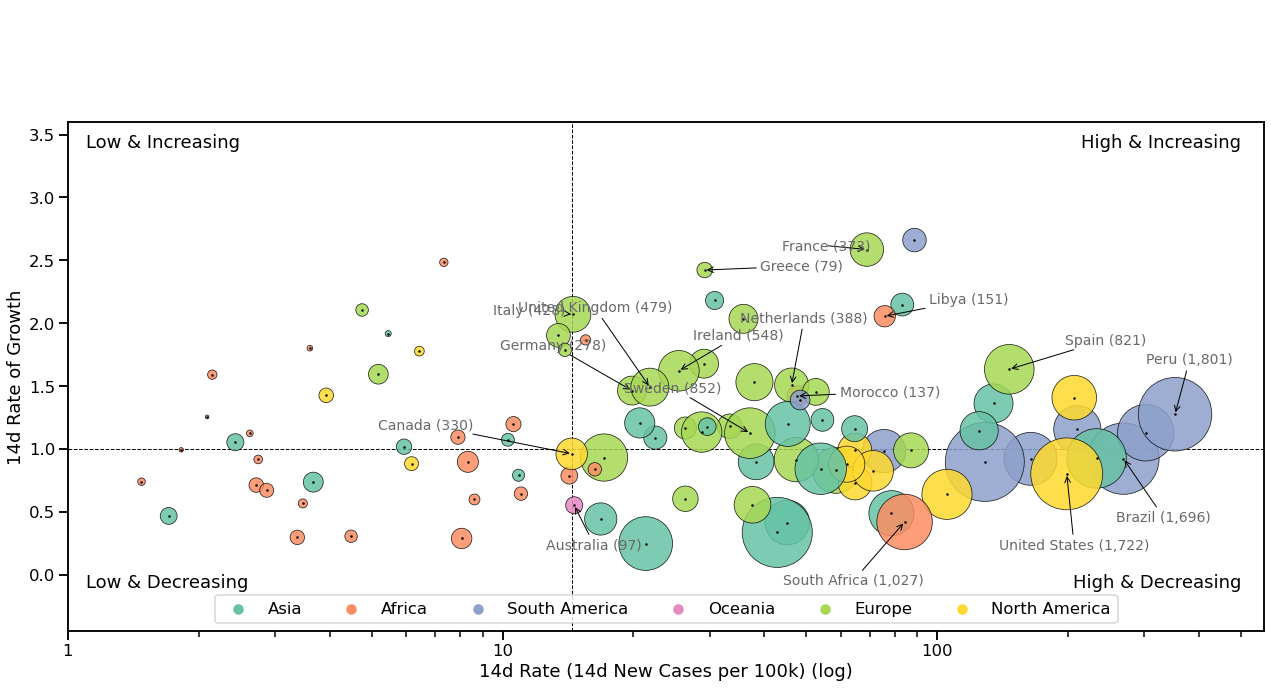

In [11]:
sns.set_context('talk')

size_scale = 3

fig, ax = plt.subplots(figsize=(18, 10))

large_pop = owid['population']>4500000
use_countries = (owid['continent'].notnull())
with_cases = owid['new_cases_14d_rate_per_100k']>0
is_country = owid['country'].notnull()

use_data = large_pop & use_countries & with_cases & is_country

current_new_cases_14d_rate_per_100k = owid[use_data].groupby(
    'country').last()['new_cases_14d_rate_per_100k']

total_cases_per_100k = (100000*owid[use_data].groupby(
    'country')['new_cases'].sum()\
    /owid[use_data].groupby('country')['population'].last())

current_rog = owid[use_data].groupby(
    'country').last()['new_cases_14d_rate_per_100k_rog'].clip(upper=100)

continent = owid[use_data].groupby(
    'country').last()['continent']

sns.scatterplot(
    current_new_cases_14d_rate_per_100k, current_rog, 
    size=total_cases_per_100k, sizes=(total_cases_per_100k.min(),total_cases_per_100k.max()*size_scale), 
    hue=continent, palette='Set2', alpha=.85,
    edgecolor='k', lw=.5,
)

ax.scatter(
    current_new_cases_14d_rate_per_100k, current_rog, 
    s=1, color='k'
)


ax.axhline(1, c='k', ls='--', lw=1, zorder=-100)
ax.axvline(current_new_cases_14d_rate_per_100k.median(), c='k', ls='--', lw=1, zorder=-100)



handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[1:7], labels[1:7], ncol=6, loc='lower center')

ax.set_xlabel('14d Rate (14d New Cases per 100k) (log)')
ax.set_ylabel('14d Rate of Growth')


ax.set_xscale('log')
ax.set_xticklabels([0, 1, 10, 100])

ax.set_xlim(1)

ax.set_ylim(-.45, 3.6)


country_offsets = [
    ('Ireland', 2, .25),
    ('United Kingdom', -11, .6),
    ('Spain', 50, .2),
    ('France', -25, 0),
    ('Germany', -10, .33),
    ('Italy', -5, 0),
    ('Netherlands', -11, .5),
    ('Greece', 10, 0),
    ('Sweden', -18, .33),

    ('United States', -60, -.6),
    ('Canada', -9.25, .2),

    ('Brazil', -10, -.5),
    ('Peru', -50, .4),
    
    ('South Africa', -40, -.5),
    ('Libya', 20, .1),
    ('Morocco', 12, 0),
    ('Central African Republic', .05, .33),
    ('Tunisia', 1, 0),
    
#     ('Oman', -50, -.3),
#     ('South Korea', -1.5, .15),

    
    ('Australia', -2, -.35),
    
]

for country, xoffset, yoffset in country_offsets:
    
    x = current_new_cases_14d_rate_per_100k.loc[country]
    y = current_rog.loc[country]
    c = int(total_cases_per_100k.loc[country])
    
    ax.annotate(
        '{} ({:,})'.format(country, c), 
        xy=(x, y), xytext=(x+xoffset, y+yoffset),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=1),
        fontsize=14, color='dimgrey'
    )
    
ax.text(1.1, 3.4, 'Low & Increasing')
ax.text(1.1, -.1, 'Low & Decreasing')

ax.text(500, 3.4, 'High & Increasing', ha='right')
ax.text(500, -.1, 'High & Decreasing', ha='right')

plt.tight_layout()

fig.savefig('../graphs/rog_by_14d_rate.png', format='png')

In [12]:
owid[use_data].groupby('country').apply(
    lambda g: g['new_cases_14d_rate_per_100k'].iloc[-1]).loc['Ireland']/owid[use_data].groupby('country').apply(
    lambda g: g['new_cases_14d_rate_per_100k'].iloc[-15]).loc['Ireland']

1.5126353790613718

# Generate GapMinder Dataset

In [13]:
from_date = pd.to_datetime('2020-02-01')
from_date

Timestamp('2020-02-01 00:00:00')

In [14]:
owid['cum_cases_per_100k'] = 100000*owid['new_cases_cumsum']/owid['population']

In [15]:
gapminder_cols = ['country', 'date', 'continent', 'new_cases_14d_rate_per_100k', 'new_cases_14d_rate_per_100k_rog', 'cum_cases_per_100k']

gapminder_df = owid[use_data & (owid['date']>from_date)][gapminder_cols].replace(np.inf, np.nan).fillna(0).sort_values(by='date')

gapminder_df['Cases/100k'] = gapminder_df['cum_cases_per_100k'].map(lambda t: round(t, 4))

gapminder_df['14-Day Rate (Cases/100k)'] = gapminder_df['new_cases_14d_rate_per_100k'].map(lambda t: round(t, 4)).clip(lower=0)

gapminder_df['14-Day Rate of Growth'] = gapminder_df['new_cases_14d_rate_per_100k_rog'].map(lambda t: round(t, 4)).clip(lower=0, upper=100)

gapminder_df['date'] = gapminder_df['date'].map(lambda ts: ts.strftime("%Y%m%d"))

gapminder_df[['country', 'date', 'continent', '14-Day Rate (Cases/100k)', '14-Day Rate of Growth', 'Cases/100k']].to_csv('../data/country_gapminder.csv', index=False)
gapminder_df[['country', 'date', 'continent', '14-Day Rate (Cases/100k)', '14-Day Rate of Growth', 'Cases/100k']].head()

,country,date,continent,14-Day Rate (Cases/100k),14-Day Rate of Growth,Cases/100k
2878,United Kingdom,20200202,Europe,0.0029,0.0,0.0029
2965,Sri Lanka,20200202,Asia,0.0047,0.0,0.0047
2964,South Korea,20200202,Asia,0.0293,0.0,0.0293
2962,China,20200202,Asia,0.9854,100.0,1.0004
2958,Russia,20200202,Europe,0.0014,0.0,0.0014


In [16]:
gapminder_df['14-Day Rate (Cases/100k)'].max()

570.2124

In [17]:
owid['new_cases_14d_rate_per_100k'].max()

1053.706236067662